# Discussion 3: Probabilistic View of Linear Regression

[CS189/289A - Fall 2020]

## Introduction

Welcome! This discussion material will cover parts of Problem 2 and 4 in HW3. It aims to give you a better understanding of an interpretation of regression as a probabilistic model and should get you started on the homework problems. We will first start with this Jupyter notebook and play around with multivariate Gaussian distribution (2D). We will consider a linear regression problem from a probabilistic view and examine the likelihood function and the posterior function.

## (a) Isocontour of Gaussian PDF

We will warm-up by getting all of you more familiar with multivariate Gaussian distribution by observing the contour of its density in 2D. Run the following code and use adjust the following parameters: mean of x and y coordinates (`mu_x` and `mu_y`), and its covariance matrix, $\Sigma \in \mathbb{R}^{2 \times 2}$, given by

$$
\Sigma = \begin{bmatrix}
\Sigma_{xx} & \Sigma_{xy} \\
\Sigma_{xy} & \Sigma_{yy}
\end{bmatrix}
$$

For some values of $\Sigma$, you may get a matrix that is no longer positive semidefinite. If that happens, move $\Sigma_{xy}$ closer to zero or just try a different set of values.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.integrate import simps
from ipywidgets import interactive

In [2]:
def plot_contour(mu_x, mu_y, s_xx, s_yy, s_xy):
    # Generate grid of points at which to evaluate pdf
    x = np.linspace(-5, 5, 500)
    y = np.linspace(-5, 5, 500)
    X,Y = np.meshgrid(x, y)
    pos = np.array([Y, X]).T
    S = [[s_xx, s_xy], [s_xy, s_yy]]
    rv = scipy.stats.multivariate_normal([mu_x, mu_y], S)
    Z = rv.pdf(pos)
    
    e, v = np.linalg.eig(S)
    v = v.T * np.sqrt(e.reshape(2, 1))
    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, Z)
    plt.arrow(mu_x, mu_y, v[0, 0], v[0, 1], width=0.1, color='r')
    plt.arrow(mu_x, mu_y, v[1, 0], v[1, 1], width=0.1, color='r')
    plt.colorbar()
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

interactive_plot = interactive(plot_contour, mu_x=(-4, 4), mu_y=(-4, 4), 
                               s_xx=(0.1, 5), s_yy=(0.1, 5), s_xy=(-5, 5))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=0, description='mu_x', max=4, min=-4), IntSlider(value=0, description='m…

Answer the following questions:

- __What happens when you change the mean?__: Changing the mean translates the Gaussian PDF.
- __What happens when you change the diagonal entries of the covariance matrix? (also notice the color bar on the right)__: Modifying the covariance matrix linearly transforms the PDF. Changing the diagonal entries while keeping the off-diagonal zero scales the PDF along x and y axes.
- __What happens when you change the off-diagonal entries?__: Doing so rotates the contour of the PDF. 

The red arrows show the two orthogonal directions with the largest and the smallest variance. They can be seen as the transformed coordinates! If you have data points drawn from a standard Gaussian distribution (i.e. $\Sigma = I$), they can be linearly transformed as if they are drawn from any Gaussian distribution with covariance matrix $\Sigma$. The transformation matrix is given by 

$$T = VS^{1/2}$$

where $V$ is the eigenvectors of $\Sigma$, and $S$ is the diagonal matrix of eigenvalues of $\Sigma$. In other words, SVD of the covariance matrix $\Sigma$ is given by

$$\Sigma = VSV^\top = TT^\top$$

The red arrows are then generated by transforming the standard unit vectors, $[0, 1], [1, 0]$, by the transformation matrix $T$.

__Why does this make sense mathematically?__ Consider PDF of an standard Gaussian: $f(x) = \frac{1}{\sqrt{2\pi}} \exp\left\{-\frac{1}{2}\|x\|_2^2\right\}$. We want to find PDF of the transformed distribution $g(z)$ where $z = Tx$. More generally, for any PDF $f(x)$, $g(z)$ is given by

$$g(z) = f(x(z)) \left| \det\left( \frac{dx}{dz} \right)\right|$$

Now see what $g(z)$ looks like for our Gaussian distribution.
\begin{align}
g(z) &= \frac{1}{\sqrt{2\pi}} \left| \det{T^{-1}} \right| \cdot \exp\left\{-\frac{1}{2}\|T^{-1}z\|_2^2\right\} \\
&= \frac{1}{\sqrt{2\pi}} \left| \frac{1}{\det{T}} \right| \cdot \exp\left\{-\frac{1}{2} z^\top (T^{-1})^\top T^{-1} z \right\} \\
&= \frac{1}{\sqrt{2\pi}} \left| \frac{1}{\sqrt{\det{\Sigma}}} \right| \cdot \exp\left\{-\frac{1}{2} z^\top (S^{-1/2}V^\top)^\top S^{-1/2}V^\top z \right\} \\
&= \frac{1}{\sqrt{2\pi(\det{\Sigma})}} \cdot \exp\left\{-\frac{1}{2} z^\top V S^{-1}V^\top z \right\} \\
&= \frac{1}{\sqrt{2\pi(\det{\Sigma})}} \cdot \exp\left\{-\frac{1}{2} z^\top \Sigma^{-1} z \right\} 
\end{align}

This shows that transforming $x$ by $T$ is equivalent to sampling $z = Tx$ from a new Gaussian distribution with covariance matrix $\Sigma$.

## (b) Linear Regression (Likelihood)

Given the following variables: a data point $x \in \mathbb{R}^d$ and its label $y^* \in \mathbb{R}$. $x$ and $y^*$ are related by the following linear function.

$$y^* = x^\top w^*$$

However, in this case, we can only observe a noisy version of $y^*$:

$$y = y^* + \epsilon = x^\top w^* + \epsilon$$

where $\epsilon \sim \mathcal{N}(0, \sigma^2)$. In other words, we are given a training set of $n$ samples: $\{(x_1,y_1),\dots,(x_n,y_n)\}$. This is the same setting as in Problem 2 of HW3 where we will later show the probabilistic interpretation of least square and ridge regression.

In [3]:
# set style for prettier plots
plt.style.use('seaborn-darkgrid')

def generate_data(n, d, sigma):
    np.random.seed(1)
    w = 1.
    X = np.random.rand(n) * 10 - 5
    y = X.dot(w) + np.random.randn(n) * sigma
    return y, X, w
    
num_samples = 200
d = 1
sigma = 1
y, X, w = generate_data(num_samples, d, sigma)

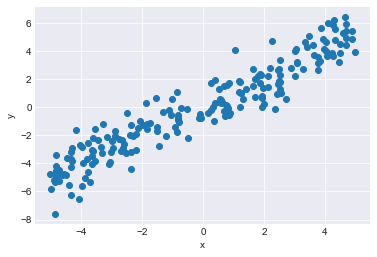

In [4]:
# Plot the data we have
plt.scatter(X, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Conditional probability of $y$ given $x$

Using the linear model given above, compute the conditional distribution $y$ given $x$, $P(y \mid x)$, as a function of $w$. Answer the following questions and __fill in the code below__.
- __What family of distribution is the conditional probability?__
- __What are its mean and variance?__

In [5]:
def conditional(y, x, w):
    """
    Arguments: y of shape (n, ), x of shape (n, ), and a scalar w.
    Return: conditional probability of shape (n, )
    """
    # TODO: Evaluate the conditional probability of y given x at some w.
    ### start 1 ##
    return np.exp(-0.5 * ((y - x.dot(w)) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    ### end 1 ###

### Maximum likelihood (ML)

We want to find the best weight $w$ that estimates the true unknown $w^*$. Given $n$ data samples $\{(x_1, y_1),\dots,(x_n, y_n)\}$, we can compute the likelihood function:

$$\text{Likelihood}(w) := p(y_1,\dots,y_n \mid x_1,\dots,x_n) = \Pi_{i=1}^n ~p(y_i \mid x_i)$$

ML solution is the weight $w$ that, as the name suggests, maximizes the likelihood of the observed data. Run the following code to plot the likelihood and the log likelihood functions. Likelihood tends to get very small very quickly so often we compute the log conditionals and sum them instead.

$$\text{Log-Likelihood}(w) := \log p(y_1,\dots,y_n \mid x_1,\dots,x_n) = \sum_{i=1}^n ~ \log p(y_i \mid x_i)$$

In [6]:
N = 200
W = np.linspace(-5, 5, N)

def compute_likelihood_1d(X, y, W, n):
    likelihood = np.zeros(N)
    for i in range(N):
        likelihood[i] = conditional(y[:n], X[:n], W[i]).prod()
    return likelihood


def compute_loglikelihood_1d(X, y, W, n):
    loglikelihood = np.zeros(N)
    for i in range(N):
        loglikelihood[i] = np.log(conditional(
            y[:n], X[:n], W[i])).sum()
    return loglikelihood


def plot_likelihood_1d(n):
    likelihood = compute_likelihood_1d(X, y, W, n)
    loglikelihood = compute_loglikelihood_1d(X, y, W, n)
    plt.figure(figsize=(10, 5))
    
    w_ml = W[likelihood.argmax()]
    ml = likelihood.max()
    
    plt.subplot(121)
    plt.plot(W, likelihood, color='blue')
    plt.vlines(w_ml, 0, ml, color='black', linestyle='--', label=r'$w_{ML}$')
    plt.xlabel('w')
    plt.ylabel('Likelihood')
    plt.xticks(np.arange(-5, 5, 1))
    plt.legend()
    
    plt.subplot(122)
    plt.plot(W, loglikelihood, color='blue')
    plt.vlines(w_ml, loglikelihood.min(), loglikelihood.max(), color='black', 
               linestyle='--', label=r'$w_{ML}$')
    plt.xlabel('w')
    plt.ylabel('Log Likelihood')
    plt.xticks(np.arange(-5, 5, 1))
    plt.legend()
    plt.show()
    
    print('ML solution: w_ml = %.8f' % w_ml)

interactive_plot = interactive(plot_likelihood_1d, n=(1, 50))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=25, description='n', max=50, min=1), Output()), _dom_classes=('widget-in…

__If your code is correct, with $n$ equal to 1, you should see a wide normal distribution with a peak density of around 0.4.__

Answer the following questions:
- __What is the ML solution? In other words, which value of $w$ maximizes the likelihood?__: $w_{ML} = 1$
- __What do you notice when $n$ increases/decreases?__ (also see the y axis): Large $n$ makes distribution more peaky or concentrated at $w^*$, and the likelihood gets smaller as $n$ increases.
- __Why does the shape of the log likelihood curve not seem to change with $n$?__: The log-likelihood curve just looks the same because of the log scale.

## (c) Linear Regression (Posterior)

Using the same model and data as in part (b), we want to take a different approach in finding the optimal $w^*$. Let's now assume that $w$ is a random variable drawn also from a Gaussian distribution with mean $\mu_w$ and variance $\sigma_w^2$, i.e. $w \sim \mathcal{N}(\mu_w, \sigma_w^2 I)$. This is an extra condition we impose on $w$, a _prior_ knowledge we have about $w$ before even seeing any data samples! So in this case, the _prior_ distribution of $w$ is $\mathcal{N}(\mu_w, \sigma_w^2 I)$.

The posterior distribution of $w$, given the same training data, is 

$$p(w \mid y_1,\dots,y_n, x_1,\dots,x_n)$$

It is the distribution of $w$ now that we see the training data. From Bayes' theorem, we can write the posterior in term of the likelihood and the prior.

\begin{align}
p(w \mid y_1,\dots,y_n, x_1,\dots,x_n) ~&=~ \frac{p(y_1,\dots,y_n \mid x_1,\dots,x_n,w) \cdot p(w \mid x_1,\dots,x_n)}{p(y_1,\dots,y_n \mid x_1,\dots,x_n)} \\
&=~ \frac{p(y_1,\dots,y_n \mid x_1,\dots,x_n,w) \cdot p(w)}{\int_w p(y_1,\dots,y_n \mid x_1,\dots,x_n,w) p(w) dw}
\end{align}

We will derive the posterior analytically in the next section as well as in Problem 1 of the homework. For now, we will plot it and see what it looks like:

In [7]:
N = 200
W = np.linspace(-5, 5, N)

def plot_posterior_1d(n, mu_w, sigma_w):
    likelihood = compute_likelihood_1d(X, y, W, n)
    prior = np.exp(-0.5 * ((W - mu_w) / sigma_w) ** 2) / (sigma_w * np.sqrt(2 * np.pi))
    py = simps(likelihood * prior, W)
    posterior = likelihood * prior / py.prod()
    w_map = W[posterior.argmax()]
    
    fig, ax1 = plt.subplots(figsize=(6, 6))
    ax1.plot(W, posterior, color='blue', label='Posterior')
    ax1.vlines(w_map, 0, posterior.max(),  color='black', 
               label=r'$w_{MAP}$', linestyle='--')
    ax1.set_xlabel('w')
    ax1.set_ylabel('Posterior')
    ax1.set_xticks(np.arange(-5, 5, 1))
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc=2)
    
    ax2 = ax1.twinx()
    ax2.plot(W, prior, color='red', label='Prior')
    ax2.set_ylabel('Prior')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend()
    
    fig.tight_layout()
    plt.show()
    
    print('MAP solution: w_map = %.8f' % w_map)

interactive_plot = interactive(plot_posterior_1d, n=(1, 25), 
                               mu_w=(-5, 5), sigma_w=(0.1, 2, 0.2))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=13, description='n', max=25, min=1), IntSlider(value=0, description='mu_…

The interactive plot may have some delay. Give it some time :)

Answer the following questions:
- __Set mean of the prior $\mu_w = 1$, what is the MAP solution?__: When $\mu_w = 1$, there is no skew because $\mu_w = w^* \approx w_{ML}$.
- __Set $\mu_w = -1$ with a large $\sigma_w$ and large $n$, what is the MAP solution?__: $w_{MAP}$ may move very slightly towards the mean of the prior $\mu_w$, but the change is so small that it is difficult to see.
- __With a small $\sigma_w$ and small $n$, how does changing $\mu_w$ affect MAP solution?__: With small $\sigma_w$ and $n$, prior has a greater effect on the posterior. MAP solution is skewed towards the mean of the prior, even though the true $w^* = 1$.
- __What is the effect of $n$ and $\sigma_w$ on the posterior?__: Larger $n$ puts more emphasis on the likelihood term so it makes MAP solution closer to the ML solution or $w^*$. Intuitively, with more samples, we are more "informed" and more confident in $w_{ML}$, and relatively the prior knowledge becomes less important. When $\sigma_w$ is large, we have a lot of uncertainty over our prior, which implies that the prior is "uninformative," so once again the likelihood dominates the posterior.

Well done! You have reached the end of the Jupyter notebook part. Go back to the worksheet and get a head start on the analytical parts!